# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

Откроем датасет и ознакомимся с данными

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Проверим на дубликаты

In [4]:
df.duplicated().sum()

4

Теперь повторим с null'ами

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучим распределение столбцов

In [7]:
df['DateCrawled'].unique()

array(['2016-03-24 11:52:17', '2016-03-24 10:58:45',
       '2016-03-14 12:52:21', ..., '2016-03-21 09:50:58',
       '2016-03-14 17:48:27', '2016-03-19 18:57:12'], dtype=object)

In [8]:
df['DateCrawled'].sort_values(ascending=False)

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
                 ...         
324763    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220583    2016-03-05 14:06:23
329497    2016-03-05 14:06:22
Name: DateCrawled, Length: 354369, dtype: object

Визуально без аномалий

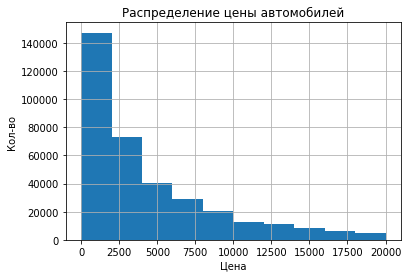

In [9]:
df['Price'].hist()
plt.title('Распределение цены автомобилей')
plt.xlabel('Цена')
plt.ylabel('Кол-во')
plt.show()

Подозрительный пик в районе нуля

In [10]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Никаких странностей

In [11]:
df['RegistrationYear'].sort_values(ascending=False)

224832    9999
326725    9999
149151    9999
217111    9999
167937    9999
          ... 
164397    1000
55605     1000
143621    1000
91869     1000
244092    1000
Name: RegistrationYear, Length: 354369, dtype: int64

In [12]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

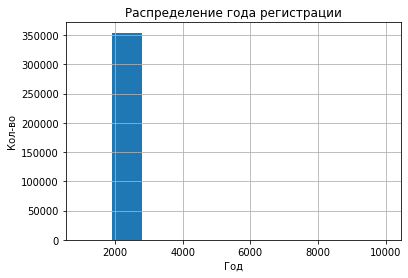

In [13]:
df['RegistrationYear'].hist(bins=10)
plt.title('Распределение года регистрации')
plt.xlabel('Год')
plt.ylabel('Кол-во')
plt.show()

Text(0.5, 1.0, 'Диаграмма выбросов года регистрации')

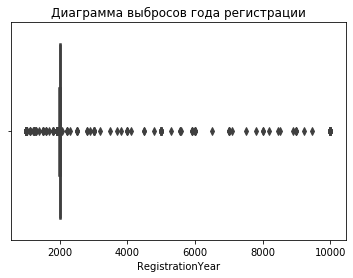

In [14]:
sns.boxplot(x=df['RegistrationYear'], linewidth=2.5).set_title('Диаграмма выбросов года регистрации')

Присутствуют выбросы в обе стороны, разберемся с ними позже

In [15]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
df['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Без нареканий

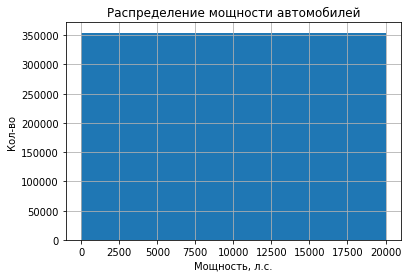

In [17]:
df['Power'].hist(bins=1)
plt.title('Распределение мощности автомобилей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Кол-во')
plt.show()

In [18]:
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

Text(0.5, 1.0, 'Диаграмма выбросов мощности автомобиля')

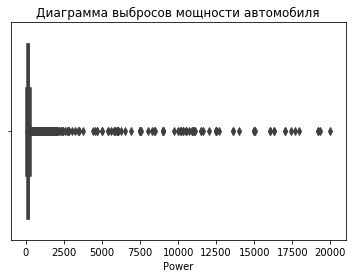

In [19]:
sns.boxplot(x=df['Power'], linewidth=2.5).set_title('Диаграмма выбросов мощности автомобиля')

Силовые способности ряда автомобилей поражают

In [20]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Модели как модели

In [21]:
df['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

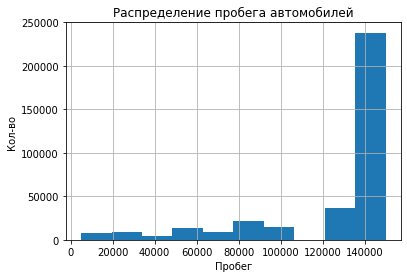

In [22]:
df['Kilometer'].hist()
plt.title('Распределение пробега автомобилей')
plt.xlabel('Пробег')
plt.ylabel('Кол-во')
plt.show()

Визуально правдаподобно

In [23]:
df['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Непонятен нулевой месяц, пока будем считать что так обозначей пропуск

In [24]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Адекватно

In [25]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Аналогично

In [26]:
df['NotRepaired'].describe()

count     283215
unique         2
top           no
freq      247161
Name: NotRepaired, dtype: object

In [27]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

В порядке

In [28]:
df['DateCreated'].sort_values(ascending=False)

305430    2016-04-07 00:00:00
309336    2016-04-07 00:00:00
206303    2016-04-07 00:00:00
176987    2016-04-07 00:00:00
134418    2016-04-07 00:00:00
                 ...         
175103    2015-08-10 00:00:00
86601     2015-08-07 00:00:00
342275    2015-06-18 00:00:00
4001      2015-03-20 00:00:00
61207     2014-03-10 00:00:00
Name: DateCreated, Length: 354369, dtype: object

In [29]:
df['DateCreated'].unique()

array(['2016-03-24 00:00:00', '2016-03-14 00:00:00',
       '2016-03-17 00:00:00', '2016-03-31 00:00:00',
       '2016-04-04 00:00:00', '2016-04-01 00:00:00',
       '2016-03-21 00:00:00', '2016-03-26 00:00:00',
       '2016-04-07 00:00:00', '2016-03-15 00:00:00',
       '2016-03-11 00:00:00', '2016-03-20 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-12 00:00:00', '2016-03-13 00:00:00',
       '2016-03-18 00:00:00', '2016-03-10 00:00:00',
       '2016-03-07 00:00:00', '2016-03-09 00:00:00',
       '2016-03-08 00:00:00', '2016-04-03 00:00:00',
       '2016-03-29 00:00:00', '2016-03-25 00:00:00',
       '2016-03-28 00:00:00', '2016-03-30 00:00:00',
       '2016-03-22 00:00:00', '2016-02-09 00:00:00',
       '2016-03-05 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-03-19 00:00:00',
       '2016-04-05 00:00:00', '2016-03-06 00:00:00',
       '2016-02-12 00:00:00', '2016-03-03 00:00:00',
       '2016-03-01 00:00:00', '2016-03-04 00:0

Визуально логично

In [30]:
df['NumberOfPictures'].describe()

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Пустовато

In [31]:
df['PostalCode'].unique()

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

Адеватно

In [32]:
df['LastSeen'].sort_values(ascending=False)

327303    2016-04-07 14:58:51
215705    2016-04-07 14:58:50
116344    2016-04-07 14:58:50
59506     2016-04-07 14:58:50
54852     2016-04-07 14:58:50
                 ...         
169065    2016-03-05 14:25:59
285695    2016-03-05 14:18:30
130462    2016-03-05 14:15:39
262341    2016-03-05 14:15:16
296785    2016-03-05 14:15:08
Name: LastSeen, Length: 354369, dtype: object

Исходя из первичного анализа значений признаков, считаю целесообразным избавить от признаков: *RegistrationMonth, PostalCode, NumberOfPictures*, т.к. вряд ли они как-либо способный повлиять на качество модели

In [33]:
df = df.drop(['RegistrationMonth', 'PostalCode', 'NumberOfPictures'], axis=1)

In [34]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21


Для удобства, приведем признаки к нижнему регистру

In [35]:
df.columns = df.columns.str.lower()

In [36]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,datecreated,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21


Избавимся от дубликатов

In [37]:
df = df.drop_duplicates()

In [38]:
df.duplicated().sum()

0

Обработаем объекты с нулевыми ценами

In [39]:
len(df.query('price == 0'))

10772

От общей массы в 350000 строк, 3% не будут являться критическим объемом, поэтому избавимся от них

In [40]:
df = df[df['price'] != 0]

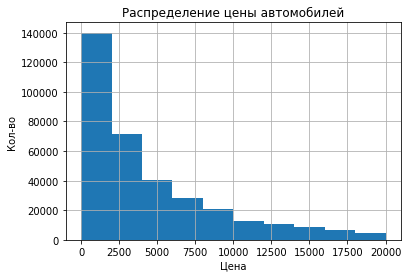

In [41]:
df['price'].hist()
plt.title('Распределение цены автомобилей')
plt.xlabel('Цена')
plt.ylabel('Кол-во')
plt.show()

Теперь разберемся со слишком мощными автомобилями

In [42]:
len(df.query('power > 1000'))

286

Также интересны "безмощные" кони

In [43]:
len(df.query('power == 0'))

36360

Итого, 10% значений. Удалять будет расточительно, забьем медианой

In [44]:
df.loc[(df['power'] > 1000) | (df['power'] <= 0), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))

In [45]:
df['power'].isna().sum()

5062

Избавимся от пропусков

In [46]:
df = df[~df['power'].isna()]

Приведем мощность к int'у

In [47]:
df['power'] = df['power'].astype('int64')

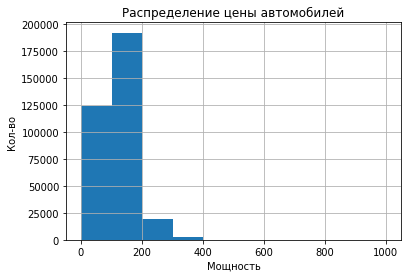

In [48]:
df['power'].hist()
plt.title('Распределение цены автомобилей')
plt.xlabel('Мощность')
plt.ylabel('Кол-во')
plt.show()

Text(0.5, 1.0, 'Диаграмма выбросов мощности')

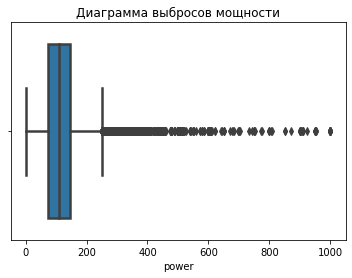

In [49]:
sns.boxplot(x=df['power'], linewidth=2.5).set_title('Диаграмма выбросов мощности')

Стало гораздо адекватнее

Переходим к моделям авто

In [50]:
df['model'].isna().sum()

12460

In [51]:
df['model'].describe()

count     326070
unique       249
top         golf
freq       28245
Name: model, dtype: object

In [52]:
number = round(12460 / 326070 * 100)
print(f'Доля пропущенных значений в признаке model: {number}%')

Доля пропущенных значений в признаке model: 4%


In [53]:
df = df[~df['model'].isna()]

In [54]:
df['model'].isnull().sum()

0

In [55]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,datecreated,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,101,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07


Переходим к признаку *vehicletype*

In [56]:
df['vehicletype'].isna().sum()

28166

Заполним самым частотным значением у автомобилей такой же модели

In [57]:
df['vehicletype'] = df['vehicletype'].fillna(df.groupby('model')['vehicletype']
                                             .transform(lambda x: x.value_counts().idxmax()))

Продублируем с *gearbox и fueltype*

In [58]:
df['gearbox'].isna().sum()

14270

In [59]:
df['fueltype'].isna().sum()

23551

In [60]:
df['gearbox'] = df['gearbox'].fillna(df.groupby('model')['gearbox']
                                             .transform(lambda x: x.value_counts().idxmax()))

In [61]:
df['fueltype'] = df['fueltype'].fillna(df.groupby('model')['fueltype']
                                             .transform(lambda x: x.value_counts().idxmax()))

Далее признак "бывалости в ремонте" *notrepaired*

In [62]:
df['notrepaired'].isna().sum()

58292

Почти 20% пропусков. Удалять не вариант

In [63]:
df['notrepaired'].value_counts()

no     235820
yes     31958
Name: notrepaired, dtype: int64

Здесь нет логики в заполнении медианой или частотным значением, пометим как неопределенный тип

In [64]:
df['notrepaired'] = df['notrepaired'].fillna('undefined')

In [65]:
df['notrepaired'].isna().sum()

0

Признак дата скачивания анкеты из базы *datecrawled* повторяет дату создания, плюс никак не повлияет на качество модели, удалим его

In [66]:
df = df.drop(['datecrawled'], axis=1)

По логике, остальные принаки с датами также не помогут повысить качество модели, дропнем из за компаниию

In [67]:
df = df.drop(['datecreated', 'lastseen'], axis=1)

In [68]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,undefined
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,undefined
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326070 entries, 0 to 354368
Data columns (total 10 columns):
price               326070 non-null int64
vehicletype         326070 non-null object
registrationyear    326070 non-null int64
gearbox             326070 non-null object
power               326070 non-null int64
model               326070 non-null object
kilometer           326070 non-null int64
fueltype            326070 non-null object
brand               326070 non-null object
notrepaired         326070 non-null object
dtypes: int64(4), object(6)
memory usage: 27.4+ MB


У года регистрации также есть вопросы, первый "автомобиль" был изобретен в 1770 году, плюс нужно избавиться от значений, у который год превышает текущий

In [70]:
len(df.query('registrationyear > 2021'))

58

In [71]:
len(df.query('registrationyear < 1770'))

25

In [72]:
df = df.query('registrationyear > 1770 & registrationyear < 2021')

In [73]:
#df = df.loc[~(df['registrationyear'] < 1770) & ~(df['registrationyear'] > 2021)]

In [74]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,undefined
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,undefined
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Взглянем на корреляцию

In [75]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,price,registrationyear,power,kilometer
price,1,0.41,0.5,-0.37
registrationyear,0.41,1,0.099,-0.22
power,0.5,0.099,1,0.097
kilometer,-0.37,-0.22,0.097,1


Закодируем категориальные признаки при помощи OHE

In [76]:
def ohe_transform(df, column):
    columns_transformed = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = df.drop(column, axis=1)
    return df.join(columns_transformed)

Скопируем датасет под преобразование категориальных признаков для модели линейной регрессии

In [77]:
df_new = df.copy()

In [78]:
for point in ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']:
    df_new = ohe_transform(df_new, point)

In [79]:
df_new.head()

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_undefined,notrepaired_yes
0,480,1993,101,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [80]:
df_new.shape

(325987, 306)

Подготовим выборки. Целевой признак *price*

In [81]:
features = df_new.drop('price', axis=1)
target = df_new['price']

In [82]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

Задействуя **StandardScaler()**, отмасштабируем признаки

In [83]:
ss = StandardScaler()
ss.fit(features_train)
columns = features_train.columns
features_train = pd.DataFrame(ss.transform(features_train), columns = columns)
features_test = pd.DataFrame(ss.transform(features_test), columns = columns)

In [84]:
features_train.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_undefined,notrepaired_yes
0,0.808769,0.449160,-1.851513,-0.25086,4.549115,-0.090466,-0.662033,-0.584764,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
1,-0.747149,0.223762,0.580032,-0.25086,-0.219823,-0.090466,1.510498,-0.584764,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,1.888458,-0.096982,2.150454,-0.329472
2,1.233110,0.054714,-1.581341,-0.25086,-0.219823,-0.090466,-0.662033,1.710091,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
3,1.091663,1.726416,-1.581341,-0.25086,-0.219823,-0.090466,-0.662033,1.710091,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
4,0.384428,-0.452432,-1.581341,-0.25086,-0.219823,-0.090466,1.510498,-0.584764,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472


In [85]:
features_test.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_undefined,notrepaired_yes
0,-0.181360,-0.828095,-0.095397,-0.25086,-0.219823,-0.090466,-0.662033,-0.584764,-0.191367,2.009196,...,7.752634,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
1,0.101534,2.872190,0.580032,-0.25086,-0.219823,-0.090466,1.510498,-0.584764,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,2.150454,-0.329472
2,-1.312937,-0.320950,0.580032,-0.25086,-0.219823,-0.090466,-0.662033,1.710091,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
3,1.940346,-0.057985,0.580032,-0.25086,-0.219823,-0.090466,1.510498,-0.584764,-0.191367,-0.497711,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472
4,0.667322,1.125355,0.580032,-0.25086,-0.219823,-0.090466,-0.662033,-0.584764,-0.191367,2.009196,...,-0.128988,-0.124157,-0.046264,-0.082193,-0.116566,-0.036078,-0.529533,-0.096982,-0.465018,-0.329472


#### Вывод

- были изучены данные и их распределение
- удалены дубликаты, обработаны пропущенные значения, отброшены нереалистичные значения
- удалены признаки, непригодные для обучения моделей
- закодированы категориальные признаки
- данные разделены на обучающую и тестовую выборки
- проведено их масштабирование

## Обучение моделей

Начнем с линейной регрессии

In [86]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predictions_lr_model = lr_model.predict(features_test)
mse_lr_model = mean_squared_error(target_test, predictions_lr_model)
print(f"RMSE для линейной модели на тестовой выборке: {(mse_lr_model) ** 0.5}")

RMSE для линейной модели на тестовой выборке: 2713.2107121800545
CPU times: user 22.7 s, sys: 8.03 s, total: 30.8 s
Wall time: 30.7 s


**CatBoostRegressor**

In [87]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,1993,manual,101,golf,150000,petrol,volkswagen,undefined
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,undefined
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [97]:
num_features = ['price', 'registrationyear', 'power', 'kilometer']
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired', 'brand']

In [98]:
features_ = df.drop(['price'],axis=1)
target_ = df['price']

features__train, features__test, target__train, target__test = train_test_split(features_, target_, test_size=0.2, random_state=12345)

In [99]:
cb_model = CatBoostRegressor(cat_features=cat_features)

In [100]:
%%time
cb_model.fit(features__train, target__train, eval_set=(features__test, target__test), verbose=200)

0:	learn: 4447.9263685	test: 4435.7629102	best: 4435.7629102 (0)	total: 1.13s	remaining: 18m 48s
200:	learn: 1867.9444784	test: 1866.7953245	best: 1866.7953245 (200)	total: 2m 46s	remaining: 11m
400:	learn: 1778.8882971	test: 1783.8348817	best: 1783.8348817 (400)	total: 5m 31s	remaining: 8m 15s
600:	learn: 1736.2574721	test: 1746.7797200	best: 1746.7797200 (600)	total: 8m 21s	remaining: 5m 32s
800:	learn: 1705.8205234	test: 1721.7731466	best: 1721.7731466 (800)	total: 11m 1s	remaining: 2m 44s
999:	learn: 1685.6227545	test: 1705.5220343	best: 1705.5220343 (999)	total: 13m 50s	remaining: 0us

bestTest = 1705.522034
bestIteration = 999

CPU times: user 12min 43s, sys: 1min 8s, total: 13min 52s
Wall time: 13min 58s


In [101]:
predictions_cb_model = cb_model.predict(features__test)
mse_cb_model = mean_squared_error(target__test, predictions_cb_model)
print(f"RMSE для модели CatBoostRegressor на тестовой выборке: {(mse_cb_model) ** 0.5}")

RMSE для модели CatBoostRegressor на тестовой выборке: 1705.5220342707225


Переходим к градиентному бустингу **LightGBM**

Как выяснилось, он тоже временами требует определенного кодирования, нашел мини-шаблон с kaggle для этого случая

In [119]:
labelencoder = LabelEncoder()

for col in cat_features:
    df[col] = labelencoder.fit_transform(df[col])

for col in cat_features:
    df[col] = df[col].astype('int')
    

y = df[["price"]]
X = df.drop(["price"], axis=1)

features___train, features___test, target___train, target___test = train_test_split(X, y, random_state = 12345)    

train_data = lgb.Dataset(features___train, 
                         label=target___train, 
                         categorical_feature=['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired', 'brand'], 
                         free_raw_data=False)
test_data = lgb.Dataset(features___test, 
                        label=target_test, 
                        categorical_feature=['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired', 'brand'], 
                        free_raw_data=False)

In [120]:
gbm_model = lgb.LGBMRegressor()

In [121]:
%%time
gbm_model.fit(features___train, target___train, eval_set=[(features___test, target___test)], eval_metric='rmse', 
              categorical_feature=cat_features)

[1]	valid_0's rmse: 4204.2	valid_0's l2: 1.76753e+07
[2]	valid_0's rmse: 3918.89	valid_0's l2: 1.53577e+07
[3]	valid_0's rmse: 3670.08	valid_0's l2: 1.34695e+07
[4]	valid_0's rmse: 3441.07	valid_0's l2: 1.1841e+07
[5]	valid_0's rmse: 3245.22	valid_0's l2: 1.05315e+07
[6]	valid_0's rmse: 3075.63	valid_0's l2: 9.45948e+06
[7]	valid_0's rmse: 2923.76	valid_0's l2: 8.54837e+06
[8]	valid_0's rmse: 2783.87	valid_0's l2: 7.74995e+06
[9]	valid_0's rmse: 2666.41	valid_0's l2: 7.10973e+06
[10]	valid_0's rmse: 2556.68	valid_0's l2: 6.53661e+06
[11]	valid_0's rmse: 2463.23	valid_0's l2: 6.06752e+06
[12]	valid_0's rmse: 2378.35	valid_0's l2: 5.65657e+06
[13]	valid_0's rmse: 2307.08	valid_0's l2: 5.32263e+06
[14]	valid_0's rmse: 2242.01	valid_0's l2: 5.02663e+06
[15]	valid_0's rmse: 2182.9	valid_0's l2: 4.76507e+06
[16]	valid_0's rmse: 2134.39	valid_0's l2: 4.55561e+06
[17]	valid_0's rmse: 2090.03	valid_0's l2: 4.36822e+06
[18]	valid_0's rmse: 2051.31	valid_0's l2: 4.20788e+06
[19]	valid_0's rmse: 2

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [125]:
predictions_gbm_model = gbm_model.predict(features___test, num_iteration=gbm_model.best_iteration_)
mse_gbm_model = mean_squared_error(target___test, predictions_gbm_model)
print(f"RMSE для модели CatBoostRegressor на тестовой выборке: {(mse_gbm_model) ** 0.5}")

RMSE для модели CatBoostRegressor на тестовой выборке: 1659.389183889744


#### Вывод

Опробованы три разных модели, получены результаты RMSE, которые будут обдуманы в следующем разделе

## Анализ моделей

Модель **LinearRegression**

- RMSE: *2713.2107121800545*
- Время работы: *30.7 s*

Модель **CatBoostRegressor**

- RMSE: *1705.5220342707225*
- Время работы: *13min 58s*

Модель **LightGBM**

- RMSE: *1659.389183889744*
- Время работы: *11.1 s*

#### Вывод

Модель линейной регрессии работает относительно быстро, но метрика RMSE слишком высока. CatBoostRegressor гораздо медленнее, но целевая метрика показала результат лучше в 0.6 раза. LightGBM действительно показал себя "шустрой" библиотекой, лучшее время работы при лучшем значении RMSE.  
  
P. S. : пытался "поиграть" с параметрами библиотек бустинга, т.к. рассчитывал выжать показатели покрасивше, но jupyter подвисает на такое время, что не дожидался окончания выполнения пода.
В связи с чем, прошу дать мне какой-либо плагин для отображения прогресс-бара в notebook и новых библиотек для бустинга, которые не рассматривались в курсе.